In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import eviltransform
from datetime import datetime
from datetime import timedelta
from datetime import timezone
import time
import math
import glob
import pytz
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# load data on 20161201
test_data = pd.read_csv('../Data_Warehouse/DiDi_XiAn/gps_20161201')
test_data.columns = ['driver_ID', 'order_ID', 'time', 'lon', 'lat']
test_data = test_data.sort_values(by=['driver_ID', 'order_ID', 'time'])

In [3]:
bound_ws = eviltransform.wgs2gcj(34.224, 108.929) # west south bound
lat_min = bound_ws[0]
lon_min = bound_ws[1]
bound_en = eviltransform.wgs2gcj(34.253, 108.958) # east north bound
lat_max = bound_en[0]
lon_max = bound_en[1]

In [4]:
data = test_data

In [5]:
# process data 
# get the previous item of each item for each trajectory
data[['pre_DID', 'pre_OID', 'pre_time', 'pre_lon', 'pre_lat']] = data[['driver_ID', 'order_ID', 'time', 'lon', 'lat']].shift(1)

data = data[ data.order_ID == data.pre_OID] # drop rows in which order_id and pre_order_id are not identical
data = data.drop(columns=['pre_DID', 'pre_OID'])
data['pre_time'] = data['pre_time'].astype(int)

In [30]:
# north
# get the trajectories information traversing the bounded area 
data_north = data[(data.lat >= 34.239406) & (data.pre_lat <= 34.232401) & (data.lon >= 108.946151) & (data.lon <= 108.947656)]

In [31]:
# get datetime
data_north['datetime'] = data_north.apply(lambda x : datetime.utcfromtimestamp(x.time) + timedelta(hours=8), axis = 1)

C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
# confine the timestamp
data_north = data_north[data_north.datetime.dt.hour >= 6]

data_north = data_north[data_north.datetime.dt.hour <= 20]

In [34]:
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = earth_radius * c
    return d

In [35]:
data_north['distance'] = data_north.apply(lambda x: calculate_distance(x.lat, x.lon, x.pre_lat, x.pre_lon), axis = 1)

In [36]:
data_north.interval = data_north.time - data_north.pre_time

C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [37]:
data_north['speed'] = data_north.distance / data_north.interval * 3.6

In [66]:
calculate_distance(34.239406, 108.946151, 34.232401, 108.946151)

778.9204611450766

In [128]:
# the north-south distance of the bounded area is around 780 meters, 
# we just select trajectories whose distance of the consecutive points traversing the study area is less than 850 
data_north_sample = data_north[data_north.distance < 850]

In [129]:
# group the speed information
speed_north = data_north_sample[['datetime', 'speed']].groupby(pd.Grouper(key = 'datetime', freq = '5Min')).mean()

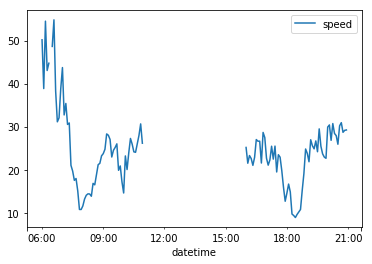

In [130]:
speed_north.plot()

In [132]:
speed_north.to_csv('./prediction/calculated_north.csv')

In [57]:
# south
data_south = data[(data.pre_lat >= 34.239406) & (data.lat <= 34.232401) & (data.lon >= 108.946151) & (data.lon <= 108.947656)]

In [58]:
data_south['datetime'] = data_south.apply(lambda x : datetime.utcfromtimestamp(x.time) + timedelta(hours=8), axis = 1)

data_south = data_south[data_south.datetime.dt.hour >= 6]

data_south = data_south[data_south.datetime.dt.hour <= 20]

data_south['distance'] = data_south.apply(lambda x: calculate_distance(x.lat, x.lon, x.pre_lat, x.pre_lon), axis = 1)

data_south.interval = data_south.time - data_south.pre_time

data_south['speed'] = data_south.distance / data_south.interval * 3.6

C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [137]:
data_south_sample = data_south[data_south.distance < 900]

In [138]:
speed_south = data_south_sample[['datetime', 'speed']].groupby(pd.Grouper(key = 'datetime', freq = '5Min')).mean()

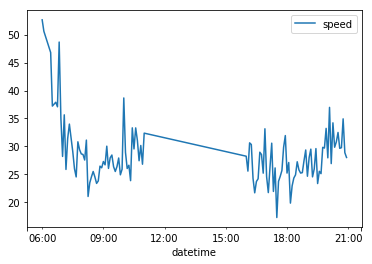

In [143]:
# interpolate missing values
speed_south.interpolate().plot()

In [145]:
speed_south.interpolate().to_csv('./prediction/calculated_south.csv')